## Setup

In [ ]:
import torch

torch.cuda.is_available()

In [ ]:
!ros2 topic info /camera_ids/image_color

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

image_cv = np.ones((1920, 2556, 3), dtype=np.uint8) * 128

In [15]:
int(2556 / 1920 * 518 / 14) * 14

686

torch.Size([1, 3, 518, 686])


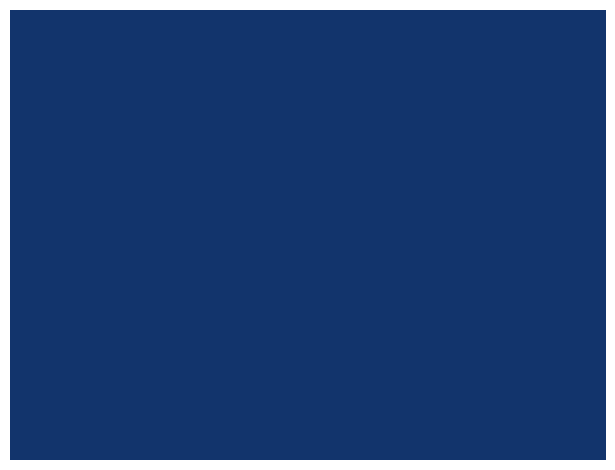

In [12]:
import torchvision.transforms.v2 as tv_transforms
import cv2

import nimbro_depthanything.models.util.transform as custom_transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 518

transform = tv_transforms.Compose(
    [
        custom_transforms.Resize(
            width=input_size,
            height=input_size,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        custom_transforms.NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        custom_transforms.PrepareForNet(),
    ]
)

image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB) / 255.0
image = transform({"image": image})["image"]
image = torch.from_numpy(image)[None, ...]

print(image.shape)

plt.axis("off")
plt.tight_layout()
plt.imshow(image[0].permute((1, 2, 0)))

## Export to ONNX

In [ ]:
# !pip install onnxscript

In [19]:
import nimbro_depthanything.scripts.export_model as export_model

export_model.export_model("depth_anything_v2_metric_hypersim_vits", shape_input=(1, 3, 686, 686))

Exporting model ...
Model exported to /root/colcon_ws/src/nimbro_depthanything/resources/models_onnx/depth_anything_v2_metric_hypersim_vits.onnx


## Build engine

In [20]:
import nimbro_depthanything.scripts.build_engine as build_engine

build_engine.build_engine("depth_anything_v2_metric_hypersim_vits", shape_input=(1, 3, 686, 686))

Building tensorrt engine ...
[09/16/2024-12:54:56] [TRT] [I] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 776, GPU 15467 (MiB)
[09/16/2024-12:54:58] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +2235, GPU +426, now: CPU 3166, GPU 15893 (MiB)
[09/16/2024-12:54:58] [TRT] [I] ----------------------------------------------------------------
[09/16/2024-12:54:58] [TRT] [I] Input filename:   /root/colcon_ws/src/nimbro_depthanything/resources/models_onnx/depth_anything_v2_metric_hypersim_vits.onnx
[09/16/2024-12:54:58] [TRT] [I] ONNX IR version:  0.0.8
[09/16/2024-12:54:58] [TRT] [I] Opset version:    17
[09/16/2024-12:54:58] [TRT] [I] Producer name:    pytorch
[09/16/2024-12:54:58] [TRT] [I] Producer version: 2.3.0
[09/16/2024-12:54:58] [TRT] [I] Domain:           
[09/16/2024-12:54:58] [TRT] [I] Model version:    0
[09/16/2024-12:54:58] [TRT] [I] Doc string:       
[09/16/2024-12:54:58] [TRT] [I] ----------------------------------------------------------------
[09/16/

## Run node

In [6]:
import IPython.display as display
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from cv_bridge import CvBridge
from message_filters import ApproximateTimeSynchronizer, Cache, Subscriber as SubscriberFilter
from rclpy.callback_groups import MutuallyExclusiveCallbackGroup, ReentrantCallbackGroup
from rclpy.duration import Duration
from rclpy.time import Time
from rclpy.node import Node
from rclpy.qos import HistoryPolicy, ReliabilityPolicy, QoSProfile
from rcl_interfaces.msg import FloatingPointRange, IntegerRange, ParameterDescriptor, ParameterType
from sensor_msgs.msg import CameraInfo, Image, PointCloud2, PointField
from std_msgs.msg import Header
from tf2_ros import TransformBroadcaster
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

import nimbro_utils.compat.point_cloud2 as point_cloud2
from nimbro_utils.parameter_handler import ParameterHandler
from nimbro_utils.tf_oracle import TFOracle

import time

from nimbro_depthanything.metric_depth.depth_anything_v2.dpt import DepthAnythingV2


class NodeDepthAnything(Node):
    def __init__(
        self,
        topic_image="/camera_ids/image_color",
        topic_inferred_depth="/camera_ids/inferred/depth/image",
        name_encoder="small",
        name_dataset="hypersim",
        max_depth=20,
    ):
        super().__init__(node_name="depth_anything")

        self.bridge_cv = None
        self.device = None
        self.name_dataset = name_dataset
        self.name_encoder = name_encoder
        self.handler_parameters = None
        self.max_depth = max_depth
        self.profile_qos = None
        self.service_colorize_points = None
        self.service_project_dome = None
        self.subscriber_image = None
        self.topic_image = topic_image
        self.topic_inferred_depth = topic_inferred_depth

        self._init()

    def _init(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bridge_cv = CvBridge()
        self.profile_qos = QoSProfile(reliability=ReliabilityPolicy.BEST_EFFORT, history=HistoryPolicy.KEEP_LAST, depth=1)
        self.handler_parameters = ParameterHandler(self, verbose=False)

        # self._init_parameters()

        # self._init_tf_oracle()
        # self._del_publishers()

        # self._del_services()
        # self._init_services()
        # self._del_subscribers()

        model_configs = {
            "small": {"encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384]},
            "base": {"encoder": "vitb", "features": 128, "out_channels": [96, 192, 384, 768]},
            "large": {"encoder": "vitl", "features": 256, "out_channels": [256, 512, 1024, 1024]},
        }

        self.model = DepthAnythingV2(**{**model_configs[self.name_encoder], "max_depth": self.max_depth})
        name_encoder_internal = model_configs[self.name_encoder]["encoder"]
        self.model.load_state_dict(torch.load(f"checkpoints/depth_anything_v2_metric_{self.name_dataset}_{name_encoder_internal}.pth"))
        self.model.eval()
        self.model.to(self.device)

        self.i = 0

        self._init_subscribers()
        self._init_publishers()

    def _init_subscribers(self):
        self.subscriber_image = self.create_subscription(Image, self.topic_image, self.infer_depth, qos_profile=self.profile_qos, callback_group=MutuallyExclusiveCallbackGroup())

    def _init_publishers(self):
        self.publisher_image = self.create_publisher(msg_type=Image, topic=self.topic_inferred_depth, qos_profile=self.profile_qos, callback_group=ReentrantCallbackGroup())

    def publish_image(self, image, name_frame, stamp):
        header = Header(stamp=stamp, frame_id=name_frame)
        message = self.bridge_cv.cv2_to_imgmsg(image, header=header, encoding="mono16")

        self.publisher_depth.publish(message)

    def visualize_depth_image(self, image_depth, image_rgb, time_needed):
        din_a4 = np.array([210, 297]) / 25.4
        din_a4_landscape = din_a4[::-1]
        fig = plt.figure(figsize=din_a4_landscape)

        def visualize_image(image):
            ax = plt.gca()
            ax.set_axis_off()
            ax.imshow(image, cmap="turbo", vmin=0)

        fig.add_subplot(1, 2, 1)
        visualize_image(image_rgb)

        fig.add_subplot(1, 2, 2)
        visualize_image(image_depth)

        plt.tight_layout()
        plt.title(f"Inference time: {time_needed:.4f}")
        # plt.savefig(Path(".") / "gif" / f"image_{self.i}")
        # self.i += 1
        plt.show()

    def infer_depth(self, message_image):
        image = self.bridge_cv.imgmsg_to_cv2(message_image, desired_encoding="passthrough")
        # image = torch.as_tensor(image, dtype=torch.float16, device=self.device)

        s = time.time()
        image_depth = self.model.infer_image(image)  # HxW depth map in meters in numpy
        e = time.time()

        self.get_logger().info(f"Inference time: {e-s}")

        self.get_logger().info(f"Mean depth: {image_depth.mean()}")
        self.get_logger().info(f"Shape: {image_depth.shape}")

        # self.publish_image(image_depth, name_frame=message_image.header.frame_id, stamp=message_image.header.stamp)

        display.clear_output(wait=True)
        time_needed = e - s
        self.visualize_depth_image(image_depth, image, time_needed)

In [ ]:
import nimbro_utils.node as utils_node
import rclpy

try:
    rclpy.shutdown()
except:
    pass

utils_node.start_and_spin_node(NodeDepthAnything)